In [1]:
#!/usr/bin/env python

# Generative Adversarial Networks (GAN) example in PyTorch.
# See related blog post at https://medium.com/@devnag/generative-adversarial-networks-gans-in-50-lines-of-code-pytorch-e81b79659e3f#.sch4xgsa9
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.backends.cudnn.benchmark = True
import matplotlib.pyplot as plt


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="6" # change 0  with whatever card is available

In [3]:
# Data params
data_mean = 4
data_stddev = 1.25

# Model params
g_input_size = 1     # Random noise dimension coming into generator, per output vector
g_hidden_size = 10   # Generator complexity
g_output_size = 1    # size of generated output state vector

m_input_size = 1   # State dimension coming into model, per output vector
m_hidden_size = 10   # Model complexity
m_output_size = 1    # size of generated output vector

minibatch_size = 100

g_learning_rate = 2e-3  # 2e-4
m_learning_rate = 2e-4  # 2e-4

optim_betas = (0.9, 0.999)
num_epochs = 50000
print_interval = 1000
m_steps = 1  # 'k' steps in the original GAN paper. Can put the discriminator on higher training freq than generator
g_steps = 1

left = -10
right = 10
# # ### Uncomment only one of these
# #(name, preprocess, d_input_func) = ("Raw data", lambda data: data, lambda x: x)
# (name, preprocess, d_input_func) = ("Data and variances", lambda data: decorate_with_diffs(data, 2.0), lambda x: x * 2)

# print("Using data [%s]" % (name))

In [4]:
def l1(x, y):
    loss = (x-y).pow(2).sum()
    return loss

def nl1(x, y):
    loss = -((x-y).pow(2).sum())
    return loss

In [5]:
# ##### DATA: Target data and generator input data
def exact_model(mu, sigma):
    return lambda x: torch.exp(-((x-mu)**2)/(2*sigma**2))/np.sqrt(6.28)/sigma  # Gaussian

def get_generator_input_sampler():
    return lambda m, n: (torch.rand(m, n)-0.5)  # Uniform-dist data into generator, _NOT_ Gaussian

# ##### MODELS: Generator model and discriminator model

class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, y):
        x = F.relu(self.map1(y))
        x = F.relu(self.map2(x))
        z = self.map3(x)
#         lt = nn.Threshold(left, left)
#         z = lt(z)
#         nrt = nn.Threshold(-right, -right)
#         z = -nrt(-z)
        return z

    def reset_parameters(self):
        stdv = 1e-3
        self.map1.weight.data.uniform_()
        self.map2.weight.data.uniform_()
        self.map3.weight.data.uniform_()

class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.map1(x))
        x = F.relu(self.map2(x))
        return self.map3(x)

# class Discriminator(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(Discriminator, self).__init__()
#         self.map1 = nn.Linear(input_size, hidden_size)
#         self.map2 = nn.Linear(hidden_size, hidden_size)
#         self.map3 = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         x = F.elu(self.map1(x))
#         x = F.elu(self.map2(x))
#         return F.sigmoid(self.map3(x))

def extract(v):
    return v.data.storage().tolist()


def stats(d):
    return [np.mean(d), np.std(d)]

def decorate_with_diffs(data, exponent):
    mean = torch.mean(data.data, 1, keepdim=True)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - Variable(mean_broadcast), exponent)
    return torch.cat([data, diffs], 1)

0 L1: M:
1.00000e-02 *
  1.4496
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.0023790958011522889, 8.2619313341100031e-05], Fake: [0.014092569341883063, 0.0028258097334737638]) 

 0.0823
 0.1121
 0.0703
 0.0813
 0.0864
 0.1019
 0.0767
 0.1149
 0.0884
 0.0844
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



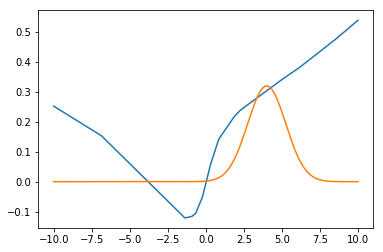

1000 L1: M:
1.00000e-04 *
  6.0290
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.0072331609873799605, 0.0064601206232104396], Fake: [0.0079198835324496026, 0.0075653145216210025]) 

-0.1139
 0.8895
 0.8895
 0.7750
-0.5159
 0.8895
-0.0728
-0.5306
 0.7853
 0.1018
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



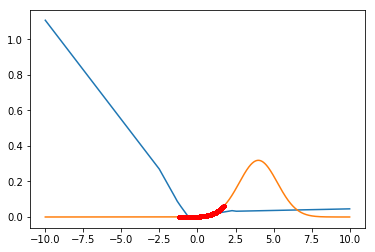

2000 L1: M:
1.00000e-05 *
  7.5364
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [5.7808377530697859e-05, 7.4170158994881784e-05], Fake: [-4.827447235584259e-05, 0.00090139560481784645]) 

-5.5584
-0.8168
-0.9989
-2.3296
-6.1368
-1.7112
-5.0161
-0.9194
-1.0825
-1.7102
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



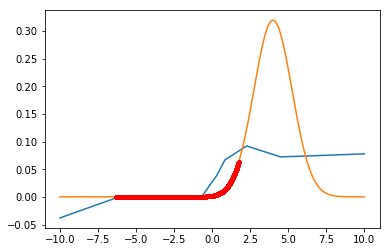

3000 L1: M:
1.00000e-06 *
  1.6529
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [6.6888101919627334e-05, 9.3084100933580767e-05], Fake: [7.8418180346488957e-05, 0.00021115519264912368]) 

-5.3417
-3.9029
-1.0088
-5.6487
-4.9170
-0.8240
-1.9471
-0.6767
-0.6939
-0.7384
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



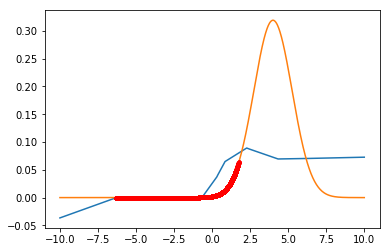

4000 L1: M:
1.00000e-07 *
  2.7960
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [9.6371963337858705e-05, 0.00010500026508946338], Fake: [8.4138959646224979e-05, 0.00013119609568277996]) 

-6.1996
-1.0254
-0.7751
-0.9673
-0.6846
-1.0597
-4.4923
-2.3777
-6.1385
-0.7046
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



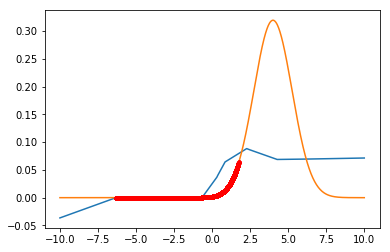

5000 L1: M:
1.00000e-08 *
  9.5952
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [6.4068162014307972e-05, 9.7223883616572517e-05], Fake: [6.8351589143276221e-05, 0.00010803189509533072]) 

-6.2098
-0.7664
-1.0452
-6.1344
-2.2623
-6.3177
-3.2073
-3.0283
-0.7079
-4.8110
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



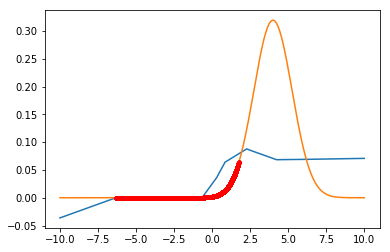

6000 L1: M:
1.00000e-09 *
  9.5407
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [6.7885365767098797e-05, 9.3675747924404674e-05], Fake: [7.5736902654170994e-05, 0.00010289240601830625]) 

-0.8191
-6.2068
-3.6773
-4.1136
-2.8433
-0.8910
-0.7622
-5.1450
-1.8875
-0.7292
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



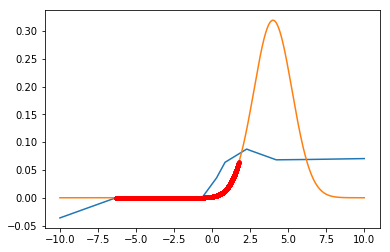

7000 L1: M:
1.00000e-08 *
  2.4066
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [7.9917511642856813e-05, 9.9454982541483884e-05], Fake: [8.701756596565246e-05, 0.00010000224469176913]) 

-1.5345
-6.0914
-5.9251
-0.9046
-0.8769
-0.9585
-0.8781
-0.7141
-0.7450
-5.1342
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



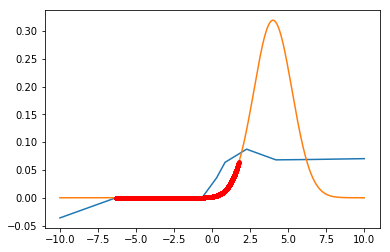

8000 L1: M:
1.00000e-08 *
  1.8920
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [7.4412343958692019e-05, 0.00010140438396618652], Fake: [7.6257139444351192e-05, 0.00010306961826850192]) 

-1.2751
-0.7147
-6.0220
-0.7371
-4.5067
-0.9341
-1.3187
-4.1955
-6.2162
-0.7793
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



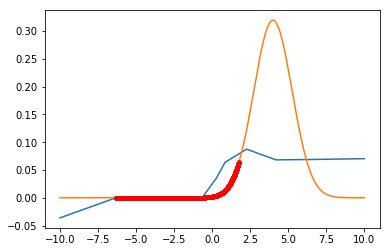

9000 L1: M:
1.00000e-08 *
  1.7864
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [7.9753030971494839e-05, 0.00010689716919453622], Fake: [8.2779265940189359e-05, 9.9454387468092361e-05]) 

-5.9620
-1.1734
-0.9748
-0.8581
-1.1778
-0.7360
-0.6748
-6.1310
-0.7907
-6.2181
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



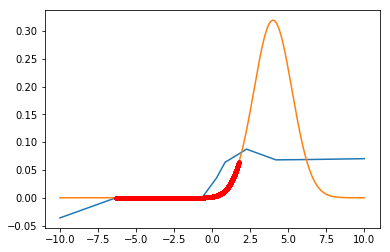

10000 L1: M:
1.00000e-08 *
  1.7520
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [9.8133851501232185e-05, 0.00010666578132417792], Fake: [7.0326365530490876e-05, 9.4384579422725521e-05]) 

-3.5586
-6.0279
-3.8982
-4.6399
-0.7945
-1.2314
-5.9494
-2.2597
-1.6072
-4.6594
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



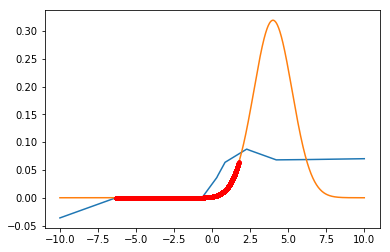

11000 L1: M:
1.00000e-08 *
  2.0302
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [8.3183890916907772e-05, 9.9017694538106448e-05], Fake: [8.5102841258049007e-05, 9.6960384709257093e-05]) 

-0.8971
-5.7435
-1.0516
-4.3161
-5.8184
-0.7045
-0.9065
-0.9535
-1.6262
-3.3203
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



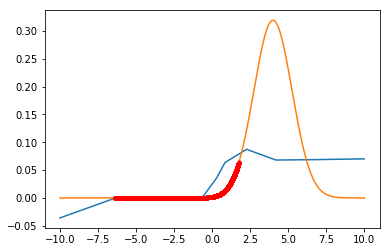

12000 L1: M:
1.00000e-02 *
  2.9669
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.19795195795595646, 0.093711335844390037], Fake: [0.19834768831729888, 0.075192470934418873]) 

 4.5828
 5.1831
 4.5803
 6.2473
 6.0395
 5.4367
 6.6351
 4.5909
 6.1832
 4.6012
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



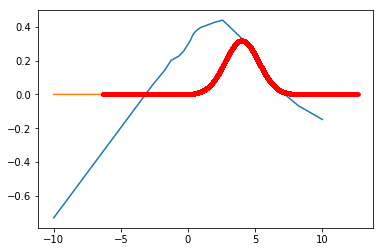

13000 L1: M:
1.00000e-04 *
  4.1031
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.16405087914317845, 0.075618207668018841], Fake: [0.17847095962613821, 0.068005888260227576]) 

 6.5280
 5.4033
 5.1475
 5.7491
 5.4265
 5.9354
 5.7781
 6.2748
 4.9493
 4.8918
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



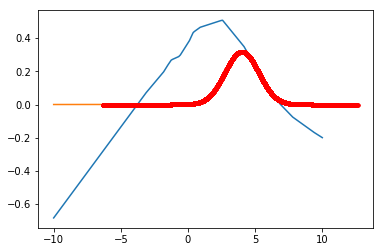

14000 L1: M:
1.00000e-05 *
  4.9744
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.00017733007396996116, 0.00052869841847759738], Fake: [0.00031840609386563301, 0.00069158172605753585]) 

 10.1878
 10.9272
 14.3733
 16.1103
 12.4796
 10.0006
  8.3380
 23.4019
 25.0736
 10.8583
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



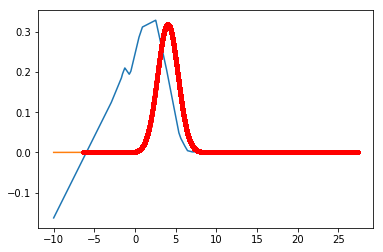

15000 L1: M:
 0.3654
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.12399259415455162, 0.10988904975125885], Fake: [0.11986759200692176, 0.045508742506603764]) 

 1.2391
 1.6784
 6.0789
 3.7795
 2.6123
 6.3936
 1.2310
 1.2238
 2.8835
 1.2473
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



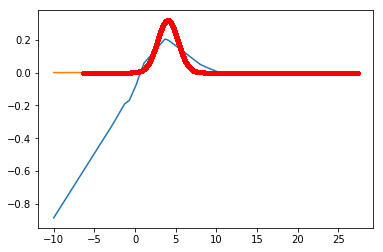

16000 L1: M:
1.00000e-03 *
  9.5966
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.1774713844805956, 0.085898242321905474], Fake: [0.16722490664571524, 0.076171991011976248]) 

 4.8166
 4.2344
 2.7335
 3.0960
 5.1479
 2.0644
 6.1986
 5.5008
 5.4291
 2.8496
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



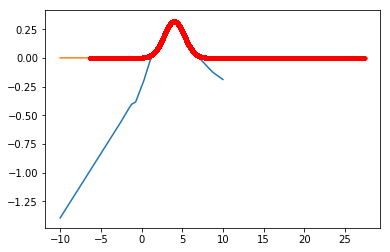

17000 L1: M:
1.00000e-03 *
  1.3006
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.19594894692301751, 0.074210766629409813], Fake: [0.20159276321530342, 0.075168514841324238]) 

 3.1444
 3.6560
 2.2723
 3.4637
 4.6383
 3.3092
 2.3564
 2.2586
 2.2472
 6.0167
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



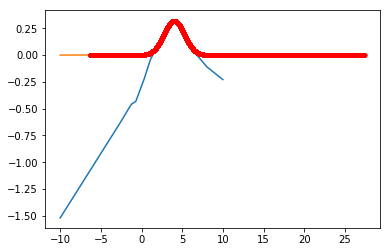

18000 L1: M:
1.00000e-04 *
  2.8764
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.20763275377452373, 0.071502397550479296], Fake: [0.21109095335006714, 0.074485508317708296]) 

 4.4196
 3.6246
 2.3579
 4.2158
 2.4688
 3.7231
 2.4005
 4.2592
 3.1314
 2.9600
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



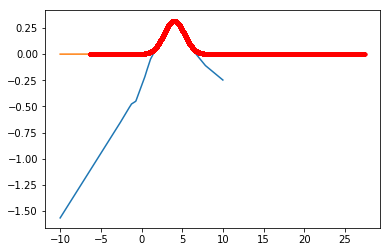

19000 L1: M:
1.00000e-03 *
  8.4629
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.056046019542691068, 0.10412431414932677], Fake: [0.077017060667276385, 0.11869167368819096]) 

  9.1196
 12.6018
 19.2543
  7.0835
 11.8779
 18.1345
 13.6311
 20.4270
 16.6043
 14.7953
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



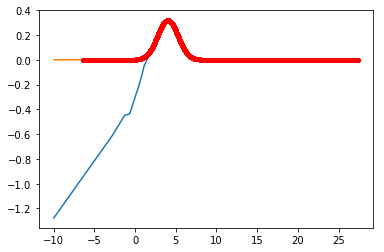

20000 L1: M:
1.00000e-04 *
  2.3980
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.062781204159874704, 0.10818991569484947], Fake: [0.060497382245957854, 0.10651078140907104]) 

 20.1622
  5.0110
  8.7965
 18.5316
 14.2502
  9.4750
  7.3023
  3.2079
 19.0124
 20.1192
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



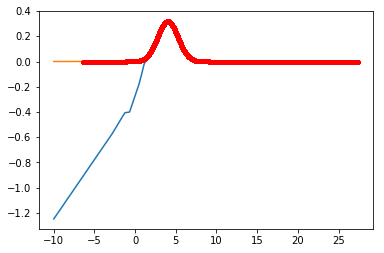

21000 L1: M:
1.00000e-04 *
  3.7730
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.076406006176305857, 0.11882925335246915], Fake: [0.08414726529270411, 0.12222664689100167]) 

 16.3030
 15.6437
 19.7449
  4.5743
  6.2808
 11.9466
 13.1057
  6.9061
 19.5223
 18.5921
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



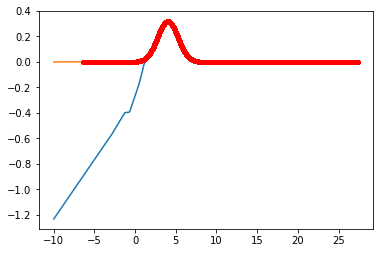

22000 L1: M:
1.00000e-04 *
  1.6098
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.066425065003520342, 0.11666511573964311], Fake: [0.065656314305961139, 0.1200299932589896]) 

 17.9030
 13.5526
  5.8230
  3.9077
 13.2395
  3.7602
  7.8808
  3.2804
  7.5183
  8.6178
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



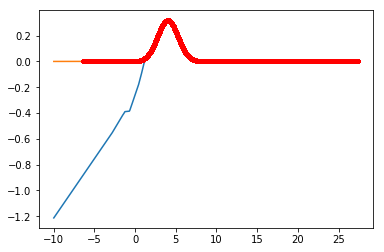

23000 L1: M:
1.00000e-04 *
  1.6036
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.06591334322118407, 0.1133774425164545], Fake: [0.089916323050856589, 0.12370559006200495]) 

 16.1130
 19.4042
 15.1171
  3.6789
 19.5273
 12.6914
 16.3158
  5.1524
  7.0661
  3.2314
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



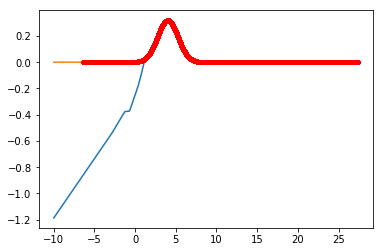

24000 L1: M:
1.00000e-04 *
  1.2493
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.085359327703741258, 0.12018360819636631], Fake: [0.076262920871376996, 0.11841055450047866]) 

 14.4703
  6.5120
 15.5961
 12.6826
  9.5110
 18.7906
  9.0769
  4.3321
 18.7480
  5.2530
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



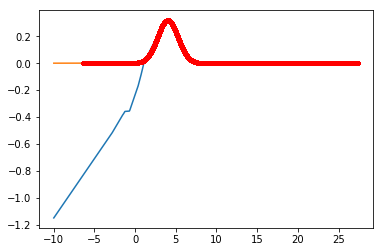

25000 L1: M:
1.00000e-05 *
  9.5649
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.10415175946858871, 0.13604529191239248], Fake: [0.080680032446980479, 0.12645272440422328]) 

 11.0528
 16.0782
  3.3830
 15.4951
  3.3922
 14.2029
 10.1856
 17.2955
  8.6460
 12.4518
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



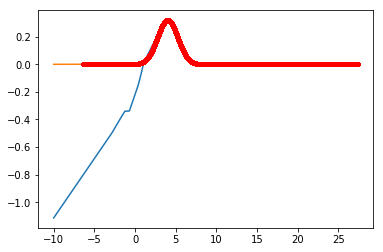

26000 L1: M:
1.00000e-04 *
  1.0668
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.091489377011879466, 0.12756776143686227], Fake: [0.08395678918808698, 0.12710867210020318]) 

  4.4792
  5.4653
 11.9253
  3.7083
 11.9884
  9.9598
  9.6379
 16.3747
  5.9421
  6.7611
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



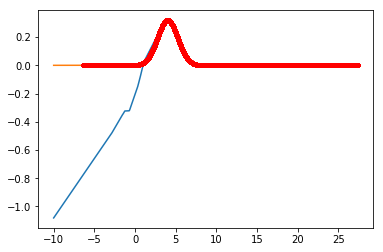

27000 L1: M:
1.00000e-05 *
  7.4433
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.11539212758984486, 0.13287359644165922], Fake: [0.10445839881896973, 0.12939483884880904]) 

  5.8796
 10.1253
  4.1634
 10.7149
  7.5221
 13.5054
  6.3474
  3.7803
 11.1905
  5.3415
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



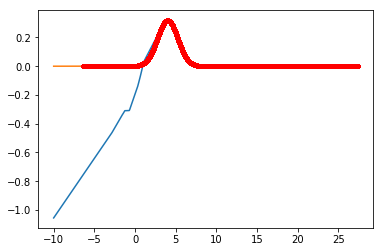

28000 L1: M:
1.00000e-05 *
  9.7290
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.11021324441122578, 0.13254548333179778], Fake: [0.12761656872928143, 0.13327651685559985]) 

  4.2161
 10.7088
 12.5953
 13.0830
  7.4591
  5.9546
 13.2520
 12.1730
 11.4661
 10.9865
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



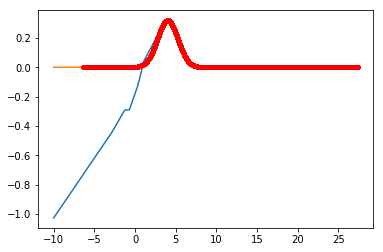

29000 L1: M:
1.00000e-03 *
  4.6783
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.10623337680270196, 0.11886388557496071], Fake: [0.09310099478811025, 0.10575664418601677]) 

 2.9783
 0.0481
 0.5108
 1.5678
 0.5633
-0.5630
 2.0487
 3.1528
-0.5357
 1.9098
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



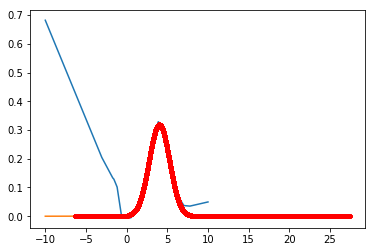

30000 L1: M:
1.00000e-04 *
  4.3104
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.078000377062126064, 0.095658224774878634], Fake: [0.075368489585816864, 0.093968484611835948]) 

-0.5285
 1.6971
 0.9446
-0.5356
 1.8638
 3.5052
-0.5542
-0.2226
-0.5598
 1.8216
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



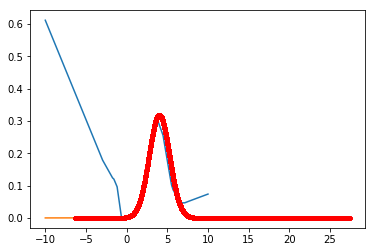

31000 L1: M:
1.00000e-04 *
  2.6335
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.11835712219966808, 0.12890971874003124], Fake: [0.12914179787039756, 0.12091024175943513]) 

 4.7593
-0.5320
 1.9640
-0.5205
 0.1877
 1.4661
 2.2170
 2.7188
 0.9129
 3.8732
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



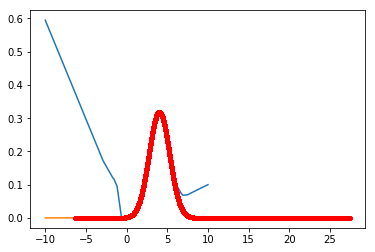

32000 L1: M:
1.00000e-04 *
  1.9187
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.13807926892972319, 0.131758979395388], Fake: [0.12565235376358033, 0.11977582373443493]) 

-0.0481
-0.5419
 1.9890
 2.6174
 4.0118
-0.5729
 0.9209
-0.5424
 4.5423
 3.4830
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



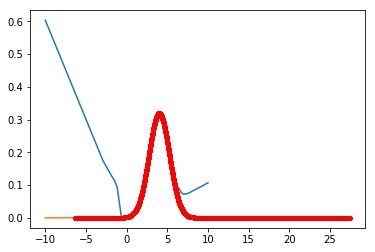

33000 L1: M:
1.00000e-04 *
  1.3372
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.11101687949965708, 0.12446647228479647], Fake: [0.10859275067225099, 0.12254135177337011]) 

 2.9939
-0.5756
-0.5686
 0.2056
 2.3740
-0.5401
 3.0848
-0.5770
-0.5534
 2.8289
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



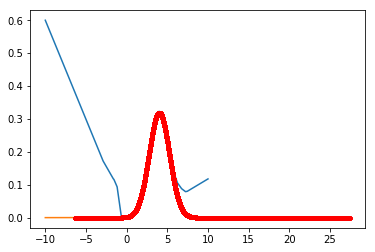

34000 L1: M:
1.00000e-04 *
  3.0063
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.043100046223155462, 0.082389949192648429], Fake: [0.06667156072333455, 0.08980519455482211]) 

-0.6398
-1.5201
-1.0051
-0.4847
-1.8148
-1.2436
 0.2750
-2.0317
-0.5394
-1.1903
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



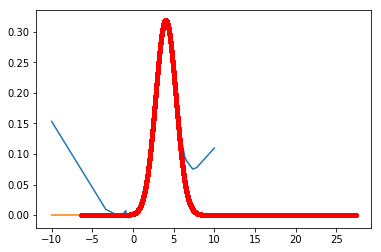

35000 L1: M:
1.00000e-05 *
  7.3212
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.070672939801447676, 0.10850568292705867], Fake: [0.072654463723301893, 0.10712643533680853]) 

-2.0513
 0.3976
 2.7417
-2.0489
 2.6808
 0.1716
-2.0408
 3.5312
-1.9781
 3.5224
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



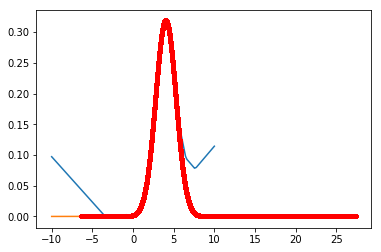

36000 L1: M:
1.00000e-04 *
  1.3140
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.078328698265027016, 0.11419694227678333], Fake: [0.091613832153379912, 0.12070309143083768]) 

-1.9546
-0.8435
 4.0939
-0.9159
 1.4320
-1.3815
-1.9582
 2.3222
 3.4064
 3.3687
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



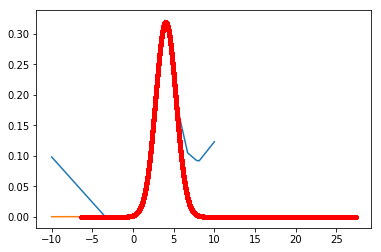

37000 L1: M:
1.00000e-04 *
  1.4749
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.05659312487399866, 0.099975952915731595], Fake: [0.063916462957859035, 0.098414355099843434]) 

 10.5843
  9.2462
  0.3508
  1.1106
  6.2759
 10.4692
 -1.2042
  9.8085
 10.9869
 -1.0393
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



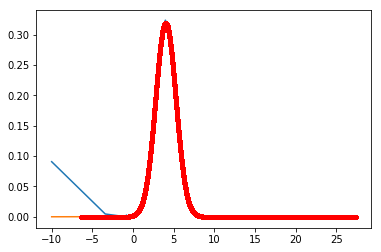

38000 L1: M:
1.00000e-04 *
  1.8003
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.065210354202626497, 0.10347417533945831], Fake: [0.067498060017824171, 0.10126236663866044]) 

-0.4107
 2.2319
-1.1392
-1.1354
-1.1405
 6.3011
 6.4587
 7.3262
 7.2276
 0.2654
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



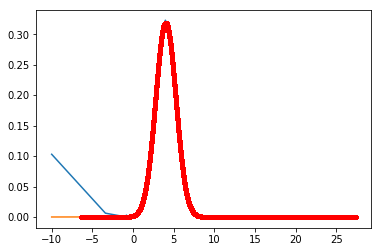

39000 L1: M:
1.00000e-04 *
  1.7889
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.12909287258016774, 0.11808104140478037], Fake: [0.12301080320030451, 0.11952987158285322]) 

 4.5321
-1.4295
 4.5572
 1.4374
 3.0577
-1.0084
-1.4295
 3.6121
 2.7676
 1.8376
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



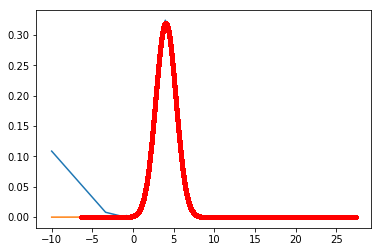

40000 L1: M:
1.00000e-04 *
  2.9941
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.13462626474818534, 0.12412384424222318], Fake: [0.15515598686411977, 0.13058841187157197]) 

 1.1029
-1.0717
-0.5859
 0.7134
-1.3559
 3.3339
 4.7096
-1.3516
 1.5437
 0.1618
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



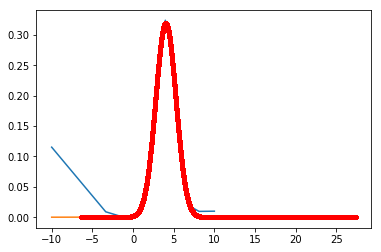

41000 L1: M:
1.00000e-04 *
  2.3165
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.14564818943323188, 0.11932720112930156], Fake: [0.15995219878852368, 0.11862128673083772]) 

-0.4671
-1.1256
-0.7887
-1.0946
 0.1689
 3.1344
 1.6541
 3.6203
-0.5984
 1.6461
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



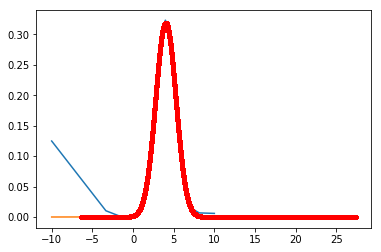

42000 L1: M:
1.00000e-04 *
  2.0441
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.17008022477035412, 0.12294532867299872], Fake: [0.15718063782900571, 0.12339122842828708]) 

 0.5041
 3.4827
 0.2748
 2.5796
 1.2497
 2.2641
 3.9231
 2.5148
 4.2359
 2.2437
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



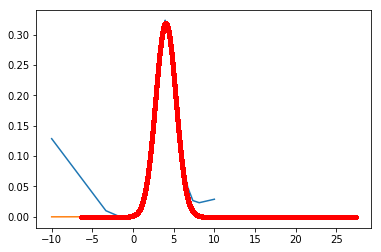

43000 L1: M:
1.00000e-04 *
  2.3676
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.15073958161752671, 0.11973147917778318], Fake: [0.16722131796181203, 0.12118049774386774]) 

 2.0380
-0.2316
 3.7305
 2.0157
 2.2479
 1.2234
 1.7719
 1.7313
 0.3387
-0.0908
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



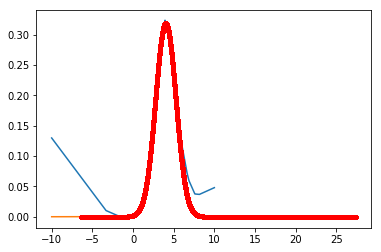

44000 L1: M:
1.00000e-04 *
  2.6202
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.15886850769515148, 0.11639263930398348], Fake: [0.13951872278004884, 0.12518284566640905]) 

 4.5503
 3.3871
 3.2629
 6.4617
 5.1107
 6.2569
 2.5844
 7.4258
 4.3542
 4.0029
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



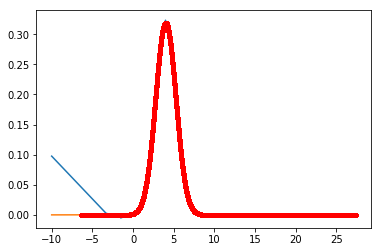

45000 L1: M:
1.00000e-04 *
  3.9961
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.20986393747851254, 0.088538488026409942], Fake: [0.18103416051715612, 0.10134361940423872]) 

 4.2694
 4.6297
 3.7293
 3.6960
 4.3920
 5.4042
 5.2119
 5.6205
 4.6670
 5.5632
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



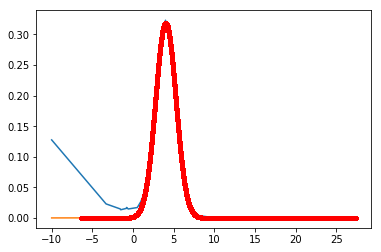

46000 L1: M:
1.00000e-04 *
  3.1998
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.25076542526483536, 0.055465294442969604], Fake: [0.24943765342235566, 0.055772088049908033]) 

 5.4196
 5.5380
 5.4000
 3.8465
 2.9596
 3.1764
 4.9013
 3.8068
 4.7578
 4.9230
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



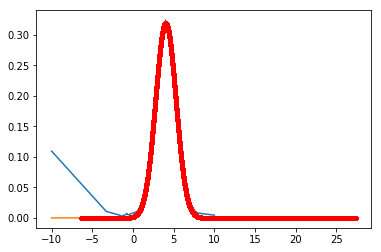

47000 L1: M:
1.00000e-04 *
  3.4065
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.29482666492462156, 0.021133958155715227], Fake: [0.29777518004178999, 0.020352377601118268]) 

 3.3835
 4.5841
 4.4705
 3.6470
 3.1765
 3.0921
 3.7605
 3.5707
 3.0448
 3.3613
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



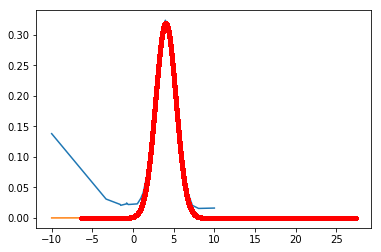

48000 L1: M:
1.00000e-04 *
  3.9707
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.30108193427324292, 0.017083496791708435], Fake: [0.29985912412405014, 0.018851474804688302]) 

 3.7675
 3.1633
 3.5508
 4.0673
 3.9134
 4.1783
 3.8358
 4.3247
 4.7260
 3.2927
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



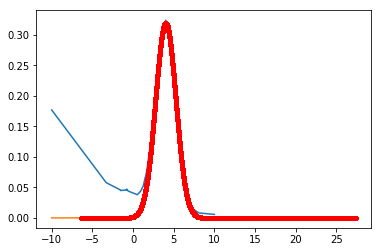

49000 L1: M:
1.00000e-04 *
  2.9464
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.26678786739706994, 0.058873605108991464], Fake: [0.25803077414631842, 0.059080532328209881]) 

 4.4933
 5.4387
 4.5664
 5.4317
 4.0860
 4.8517
 4.0239
 4.4479
 4.2560
 4.8408
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



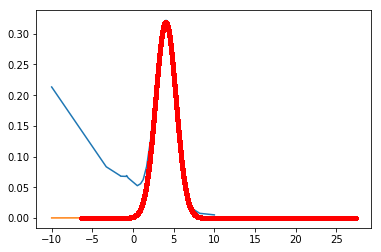

50000 L1: M:
1.00000e-04 *
  2.1114
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.30132590860128405, 0.016781265237571955], Fake: [0.3013032129406929, 0.018292400778620103]) 

 3.2146
 3.6132
 3.5489
 4.3757
 3.4106
 3.1523
 3.1917
 4.5195
 4.1865
 3.3410
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



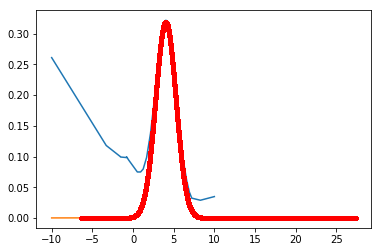

51000 L1: M:
1.00000e-04 *
  2.1413
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.18060835565440356, 0.1102309576256566], Fake: [0.19080062482506036, 0.11234318716386341]) 

 5.0381
 4.4664
 3.7557
 3.3112
 4.8355
 6.1206
 6.2290
 6.4531
 5.3236
 5.5302
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



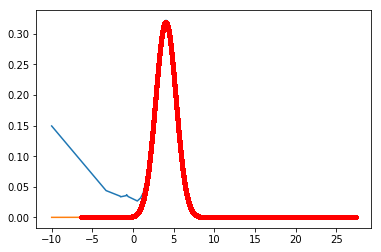

52000 L1: M:
1.00000e-04 *
  8.0681
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.20907037448137999, 0.091246484308360645], Fake: [0.21793683491647242, 0.081783471205267452]) 

 1.7809
 3.4733
 1.7680
 3.7918
 3.8273
 3.5490
 2.3693
 1.8285
 3.0688
 3.7608
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



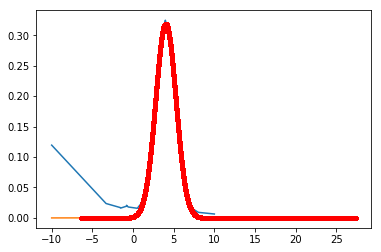

53000 L1: M:
1.00000e-04 *
  3.5738
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 mu, std (Real: [0.24339334391057491, 0.073028022557518585], Fake: [0.25224442020058629, 0.072262389896238788]) 

 3.9216
 3.4921
 4.2803
 2.1644
 2.6422
 2.9885
 2.6999
 2.7400
 4.4039
 2.6156
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



KeyboardInterrupt: 

In [6]:
exact_sampler = exact_model(data_mean, data_stddev)
gi_sampler = get_generator_input_sampler()

G = Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=g_output_size)
# G.cuda()
M = Model(input_size=m_input_size, hidden_size=m_hidden_size, output_size=m_output_size)
# M.cuda()

g_criterion = nl1  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
consta = Variable(torch.Tensor([-1]).double())
m_criterion = l1  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss

g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=optim_betas)
m_optimizer = optim.Adam(M.parameters(), lr=m_learning_rate, betas=optim_betas)
total_states = np.zeros((num_epochs*g_steps,minibatch_size))
total_exacts = np.zeros((num_epochs*g_steps,minibatch_size))

for epoch in range(num_epochs):

    for m_index in range(m_steps):
        # 1. Train D on real+fake
        M.zero_grad()
        #  1B: Train D on fake
        gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
        states = G(gen_input)
        m_fake_data = M(states)
        true_data = exact_sampler(states)
        m_error = m_criterion(m_fake_data, true_data)  # we want to fool, so pretend it's all genuine
        m_error.backward()
        m_optimizer.step()  # Only optimizes G's parameters
        
    for g_index in range(g_steps):
        # 2. Train G on D's response (but DO NOT train D on these labels)
        G.zero_grad()
        gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
        states = G(gen_input)
        total_states[epoch*g_steps+g_index, :] = states.cpu().data.numpy().ravel()
        g_fake_data = M(states)
        true_data = exact_sampler(states)
        total_exacts[epoch*g_steps+g_index, :] = true_data.cpu().data.numpy().ravel()
        
        g_error = g_criterion(g_fake_data, true_data)  # we want to fool, so pretend it's all genuine
        g_error.backward()
        g_optimizer.step()  # Only optimizes G's parameters


    if epoch % print_interval == 0:
        print("%s L1: M:%s \n mu, std (Real: %s, Fake: %s) " % (epoch, m_error.data,stats(extract(true_data)),stats(extract(m_fake_data))))#        
        print("%s" % (states.data[:10]))   
        xx = np.linspace(-10,10,1000)
        
        plt.plot(xx, M(Variable(torch.Tensor(xx).view(-1,1).float())).cpu().data.numpy())
        plt.plot(xx, exact_sampler(Variable(torch.Tensor(xx).view(-1,1).float())).cpu().data.numpy())
        plt.plot(total_states[:epoch*g_steps,:].ravel(), total_exacts[:epoch*g_steps,:].ravel(), 'r.')
        plt.show()
#         G.reset_parameters()

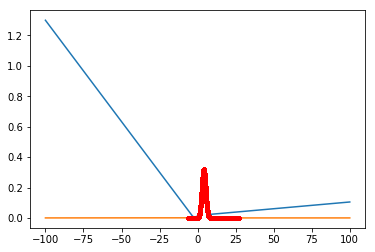

In [7]:
# import matplotlib.pyplot as plt
xx = np.linspace(-100,100,1000)

plt.plot(xx, M(Variable(torch.Tensor(xx).view(-1,1).float())).cpu().data.numpy())
plt.plot(xx, exact_sampler(Variable(torch.Tensor(xx).view(-1,1).float())).cpu().data.numpy())
plt.plot(total_states[:epoch*g_steps,:].ravel(), total_exacts[:epoch*g_steps,:].ravel(), 'r.')
plt.show()